In [1]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave, imread
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import itertools
import json

plt.rcParams["figure.figsize"] = (15,7)

# Reloading images

In [2]:
%%time
image = imread('/mnt/DATA/sandbox/lung_on_chip/20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_57.vsi - 001 CF405, CF488, CF561, CF638.tif')
zo1 = image[...,3]
dapi = image[...,0]
pdpn = image[...,2]
spc = image[...,1]
apical_mask_stack = imread('/mnt/DATA/sandbox/lung_on_chip/pp_apical_masks.tif')
basal_mask_stack = imread('/mnt/DATA/sandbox/lung_on_chip/pp_basal_masks.tif')

CPU times: user 1.12 s, sys: 2.21 s, total: 3.32 s
Wall time: 3.83 s


In [4]:
image.shape

(81, 2304, 2304, 4)

### Defining properties to measure similarities of z-slices

In [5]:
props = ('axis_major_length', 
         'axis_minor_length', 
         'eccentricity', 
         'area', 
         'mean_intensity', 
         #'intensity_image', 
         'orientation')

In [6]:
%%time
apical_pdpn_objects = btrack.utils.segmentation_to_objects(
    apical_mask_stack, 
    pdpn,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
apical_pdpn_objects = [obj for obj in apical_pdpn_objects if obj.properties['area'] > 50]

[INFO][2022/09/15 10:27:03 AM] Localizing objects from segmentation...
[INFO][2022/09/15 10:27:03 AM] Found intensity_image data
[INFO][2022/09/15 10:27:03 AM] Calculating weighted centroids using intensity_image
[INFO][2022/09/15 10:27:26 AM] Objects are of type: <class 'dict'>
[INFO][2022/09/15 10:27:26 AM] ...Found 42052 objects in 81 frames.


CPU times: user 21 s, sys: 1.57 s, total: 22.5 s
Wall time: 22.5 s


In [7]:
%%time
basal_pdpn_objects = btrack.utils.segmentation_to_objects(
    basal_mask_stack, 
    pdpn,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
basal_pdpn_objects = [obj for obj in basal_pdpn_objects if obj.properties['area'] > 50]

[INFO][2022/09/15 10:27:26 AM] Localizing objects from segmentation...
[INFO][2022/09/15 10:27:26 AM] Found intensity_image data
[INFO][2022/09/15 10:27:26 AM] Calculating weighted centroids using intensity_image
[INFO][2022/09/15 10:27:33 AM] Objects are of type: <class 'dict'>
[INFO][2022/09/15 10:27:33 AM] ...Found 913 objects in 79 frames.


CPU times: user 1min 45s, sys: 3.71 s, total: 1min 49s
Wall time: 7.25 s


In [8]:
%%time
apical_spc_objects = btrack.utils.segmentation_to_objects(
    apical_mask_stack, 
    spc,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
apical_spc_objects = [obj for obj in apical_spc_objects if obj.properties['area'] > 50]

[INFO][2022/09/15 10:27:33 AM] Localizing objects from segmentation...
[INFO][2022/09/15 10:27:33 AM] Found intensity_image data
[INFO][2022/09/15 10:27:33 AM] Calculating weighted centroids using intensity_image
[INFO][2022/09/15 10:27:55 AM] Objects are of type: <class 'dict'>
[INFO][2022/09/15 10:27:55 AM] ...Found 42052 objects in 81 frames.


CPU times: user 23 s, sys: 1.57 s, total: 24.6 s
Wall time: 21.8 s


In [9]:
%%time
basal_spc_objects = btrack.utils.segmentation_to_objects(
    basal_mask_stack, 
    spc,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
basal_spc_objects = [obj for obj in basal_spc_objects if obj.properties['area'] > 50]

[INFO][2022/09/15 10:27:55 AM] Localizing objects from segmentation...
[INFO][2022/09/15 10:27:55 AM] Found intensity_image data
[INFO][2022/09/15 10:27:55 AM] Calculating weighted centroids using intensity_image
[INFO][2022/09/15 10:28:02 AM] Objects are of type: <class 'dict'>
[INFO][2022/09/15 10:28:02 AM] ...Found 913 objects in 79 frames.


CPU times: user 1min 36s, sys: 3.08 s, total: 1min 39s
Wall time: 6.46 s


##### Tracking apical objs

In [10]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(apical_pdpn_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  apical_pdpn_tracks = tracker.tracks
  # filter tracks
  apical_pdpn_tracks = [track for track in apical_pdpn_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  apical_pdpn_data, properties, graph = tracker.to_napari()
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(apical_spc_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  apical_spc_tracks = tracker.tracks
  # filter tracks
  apical_spc_tracks = [track for track in apical_spc_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  apical_spc_data, properties, graph = tracker.to_napari()

[INFO][2022/09/15 10:28:11 AM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/09/15 10:28:11 AM] btrack (v0.4.5) library imported
[INFO][2022/09/15 10:28:11 AM] Starting BayesianTracker session
[INFO][2022/09/15 10:28:11 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/09/15 10:28:11 AM] Objects are of type: <class 'list'>
[INFO][2022/09/15 10:28:11 AM] Starting tracking... 
[INFO][2022/09/15 10:28:12 AM] Tracking objects in frames 0 to 81 (of 81)...
[INFO][2022/09/15 10:29:18 AM]  - Timing (Bayesian updates: 0.03ms, Linking: 0.07ms)
[INFO][2022/09/15 10:29:18 AM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/09/15 10:29:18 AM] SUCCESS.
[INFO][2022/09/15 10:29:18 AM]  - Found 5004 tracks in 81 frames (in 0.0s)
[INFO][2022/09/15 10:29:18 AM]  - Inserted 2969 dummy objects to fill tracking gaps
[INFO][2022/09/15 10:29:18 AM] Loading hypothesis model: 

GLPK Integer Optimizer 5.0
20016 rows, 16413 columns, 22818 non-zeros
16413 integer variables, all of which are binary
Preprocessing...
10008 rows, 16413 columns, 22818 non-zeros
16413 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 10008
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
10008 rows, 16413 columns, 22818 non-zeros
*     0: obj =   6.597361168e+04 inf =   0.000e+00 (3396)
Perturbing LP to avoid stalling [1085]...
Removing LP perturbation [3353]...
*  3353: obj =   4.657495723e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3353: mip =     not found yet >=              -inf        (1; 0)
+  3353: >>>>>   4.657495723e+04 >=   4.657495723e+04   0.0% (1; 0)
+  3353: mip =   4.657495723e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2022/09/15 10:29:20 AM] Ending BayesianTracker session
[INFO][2022/09/15 10:29:21 AM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/09/15 10:29:21 AM] btrack (v0.4.5) library imported
[INFO][2022/09/15 10:29:21 AM] Starting BayesianTracker session
[INFO][2022/09/15 10:29:21 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/09/15 10:29:21 AM] Objects are of type: <class 'list'>
[INFO][2022/09/15 10:29:21 AM] Starting tracking... 
[INFO][2022/09/15 10:29:21 AM] Tracking objects in frames 0 to 81 (of 81)...
[INFO][2022/09/15 10:30:26 AM]  - Timing (Bayesian updates: 0.03ms, Linking: 0.06ms)
[INFO][2022/09/15 10:30:26 AM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/09/15 10:30:26 AM] SUCCESS.
[INFO][2022/09/15 10:30:26 AM]  - Found 5001 tracks in 81 frames (in 0.0s)
[INFO][2022/09/15 10:30:26 AM]  - Inserted 2965 dummy objects to fill tracking 

GLPK Integer Optimizer 5.0
20004 rows, 16407 columns, 22812 non-zeros
16407 integer variables, all of which are binary
Preprocessing...
10002 rows, 16407 columns, 22812 non-zeros
16407 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 10002
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
10002 rows, 16407 columns, 22812 non-zeros
*     0: obj =   6.592216908e+04 inf =   0.000e+00 (3393)
Perturbing LP to avoid stalling [1074]...
Removing LP perturbation [3336]...
*  3336: obj =   4.661865138e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3336: mip =     not found yet >=              -inf        (1; 0)
+  3336: >>>>>   4.661865138e+04 >=   4.661865138e+04   0.0% (1; 0)
+  3336: mip =   4.661865138e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2022/09/15 10:30:29 AM] Ending BayesianTracker session


##### Tracking basal objects

In [23]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(basal_pdpn_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  basal_pdpn_tracks = tracker.tracks
  # filter tracks
  basal_pdpn_tracks = [track for track in basal_pdpn_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  basal_pdpn_data, properties, graph = tracker.to_napari()
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(basal_spc_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  basal_spc_tracks = tracker.tracks
  # filter tracks
  basal_spc_tracks = [track for track in basal_spc_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  basal_spc_data, properties, graph = tracker.to_napari()

[INFO][2022/09/15 11:05:23 AM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/09/15 11:05:23 AM] btrack (v0.4.5) library imported
[INFO][2022/09/15 11:05:23 AM] Starting BayesianTracker session
[INFO][2022/09/15 11:05:23 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/09/15 11:05:23 AM] Objects are of type: <class 'list'>
[INFO][2022/09/15 11:05:23 AM] Starting tracking... 
[INFO][2022/09/15 11:05:23 AM] Tracking objects in frames 0 to 79 (of 79)...
[INFO][2022/09/15 11:05:23 AM]  - Timing (Bayesian updates: 0.01ms, Linking: 0.02ms)
[INFO][2022/09/15 11:05:23 AM]  - Probabilities (Link: 0.99301, Lost: 1.00000)
[INFO][2022/09/15 11:05:23 AM] SUCCESS.
[INFO][2022/09/15 11:05:23 AM]  - Found 350 tracks in 79 frames (in 0.0s)
[INFO][2022/09/15 11:05:23 AM]  - Inserted 119 dummy objects to fill tracking gaps
[INFO][2022/09/15 11:05:23 AM] Loading hypothesis model: pa

GLPK Integer Optimizer 5.0
1400 rows, 1126 columns, 1552 non-zeros
1126 integer variables, all of which are binary
Preprocessing...
700 rows, 1126 columns, 1552 non-zeros
1126 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 700
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
700 rows, 1126 columns, 1552 non-zeros
*     0: obj =   4.595111432e+03 inf =   0.000e+00 (401)
*   425: obj =   1.697624208e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   425: mip =     not found yet >=              -inf        (1; 0)
+   425: >>>>>   1.697624208e+03 >=   1.697624208e+03   0.0% (1; 0)
+   425: mip =   1.697624208e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
GLPK Integer Optimizer 5.0
1424 rows, 1151 columns, 1590 non-zeros
1151 i

[INFO][2022/09/15 11:05:23 AM]  - Fates.FALSE_POSITIVE: 320 (of 356)
[INFO][2022/09/15 11:05:23 AM]  - Fates.LINK: 9 (of 83)
[INFO][2022/09/15 11:05:23 AM]  - Fates.INITIALIZE_FRONT: 1 (of 8)
[INFO][2022/09/15 11:05:23 AM]  - Fates.INITIALIZE_LAZY: 26 (of 348)
[INFO][2022/09/15 11:05:23 AM]  - Fates.TERMINATE_BACK: 2 (of 7)
[INFO][2022/09/15 11:05:23 AM]  - Fates.TERMINATE_LAZY: 25 (of 349)
[INFO][2022/09/15 11:05:23 AM]  - TOTAL: 1151 hypotheses
[INFO][2022/09/15 11:05:23 AM] Completed optimization with 347 tracks
[INFO][2022/09/15 11:05:23 AM] Ending BayesianTracker session


In [12]:
apical_pdpn_tracks[45]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity,axis_minor_length,area,orientation,axis_major_length,eccentricity
0,70,12,2178.689733,1474.933601,0.00000,70,70,5,0,False,127.193096,24.383460,927.0,0.432153,50.509851,0.875760
1,70,13,2178.689733,1474.933601,0.00000,70,70,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
2,70,14,2178.984935,1462.424728,0.00000,70,70,5,0,False,127.967573,29.284643,956.0,0.524285,42.530969,0.725190
3,70,15,2167.119386,1448.362380,0.00000,70,70,5,0,False,126.507763,25.939955,1095.0,0.693714,60.026815,0.901807
4,70,16,2160.908169,1428.381467,0.00000,70,70,5,0,False,125.708806,34.216657,1147.0,0.497816,43.377595,0.614638
5,70,17,2152.575721,1414.992771,-4.44764,70,70,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
6,70,18,2124.497208,1409.308869,0.00000,70,70,5,0,False,178.098720,24.991530,547.0,-1.499032,29.966480,0.551790


In [13]:
apical_spc_tracks[45]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity,axis_minor_length,area,orientation,axis_major_length,eccentricity
0,70,12,2178.498789,1474.637619,0.000000,70,70,5,0,False,119.382956,24.383460,927.0,0.432153,50.509851,0.875760
1,70,13,2178.498789,1474.637619,0.000000,70,70,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
2,70,14,2178.814614,1462.323769,0.000000,70,70,5,0,False,122.197699,29.284643,956.0,0.524285,42.530969,0.725190
3,70,15,2167.049725,1448.372740,0.000000,70,70,5,0,False,122.501370,25.939955,1095.0,0.693714,60.026815,0.901807
4,70,16,2160.663917,1428.421867,0.000000,70,70,5,0,False,120.911944,34.216657,1147.0,0.497816,43.377595,0.614638
5,70,17,2152.251608,1415.023999,-4.493264,70,70,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
6,70,18,2124.418899,1409.308408,0.000000,70,70,5,0,False,178.180987,24.991530,547.0,-1.499032,29.966480,0.551790


#### Eliminating tracks that have dummy figures in them

Because these contain n/a intensity measures

In [27]:
spc_apical_dummy_count = 0
pdpn_apical_dummy_count = 0
spc_apical_tracks_final, pdpn_apical_tracks_final = [], []
for spc_track, pdpn_track in zip(apical_pdpn_tracks, apical_spc_tracks):
    if any(spc_track.dummy) == True:
        spc_apical_dummy_count+=1
    else:
        spc_apical_tracks_final.append(spc_track)
    if any(pdpn_track.dummy) == True:
        pdpn_apical_dummy_count+=1
    else:    
        pdpn_apical_tracks_final.append(pdpn_track)
#     for prop in spc_track.properties:
#         if (spc_track.properties[prop] != pdpn_track.properties[prop]).all():
#             print(spc_track.ID, prop)
spc_basal_dummy_count = 0
pdpn_basal_dummy_count = 0
spc_basal_tracks_final, pdpn_basal_tracks_final = [], []
for spc_track, pdpn_track in zip(basal_pdpn_tracks, basal_spc_tracks):
    if any(spc_track.dummy) == True:
        spc_basal_dummy_count+=1
    else:
        spc_basal_tracks_final.append(spc_track)
    if any(pdpn_track.dummy) == True:
        pdpn_basal_dummy_count+=1
    else:    
        pdpn_basal_tracks_final.append(pdpn_track)

In [29]:
len(apical_spc_tracks), len(apical_pdpn_tracks),spc_dummy_count, pdpn_dummy_count

(3378, 3370, 1046, 1026)

In [16]:
pdpn_tracks_final[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity,axis_minor_length,area,orientation,axis_major_length,eccentricity
0,15,7,2287.846448,1663.514464,0.0,15,15,5,0,False,113.550669,32.050459,1046,0.515723,43.713975,0.680029
1,15,8,2291.462404,1661.806785,0.0,15,15,5,0,False,114.490358,26.250958,726,0.219159,37.102441,0.706687
2,15,9,2288.445388,1659.892172,0.0,15,15,5,0,False,115.020325,34.250415,984,-0.159798,38.251854,0.445278
3,15,10,2289.406991,1661.147509,0.0,15,15,5,0,False,117.200000,31.155184,795,-0.574319,34.012948,0.401224
4,15,11,2288.968062,1660.947667,0.0,15,15,5,0,False,118.210648,30.996510,864,0.539975,36.865712,0.541353
5,15,12,2289.141497,1664.219770,0.0,15,15,5,0,False,120.713710,33.751205,992,0.495666,42.308664,0.603005
6,15,13,2290.126537,1662.767883,0.0,15,15,5,0,False,125.209677,31.304969,806,0.311344,35.139809,0.454260
7,15,14,2290.151591,1662.969949,0.0,15,15,5,0,False,129.490518,31.243537,791,0.573344,35.761660,0.486537
8,15,15,2290.513728,1662.692576,0.0,15,15,5,0,False,137.946545,30.678909,767,0.299430,34.346046,0.449601
9,15,16,2290.548953,1662.113423,0.0,15,15,5,0,False,147.521971,30.559780,751,0.428055,33.767246,0.425385


In [21]:
spc_tracks_final[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity,axis_minor_length,area,orientation,axis_major_length,eccentricity
0,15,7,2287.795728,1663.543978,0.0,15,15,5,0,False,117.574570,32.050459,1046,0.515723,43.713975,0.680029
1,15,8,2291.395919,1661.764920,0.0,15,15,5,0,False,119.020661,26.250958,726,0.219159,37.102441,0.706687
2,15,9,2288.370132,1659.825604,0.0,15,15,5,0,False,119.238821,34.250415,984,-0.159798,38.251854,0.445278
3,15,10,2289.322179,1661.056808,0.0,15,15,5,0,False,120.586164,31.155184,795,-0.574319,34.012948,0.401224
4,15,11,2288.823962,1660.941448,0.0,15,15,5,0,False,120.936343,30.996510,864,0.539975,36.865712,0.541353
5,15,12,2288.926378,1664.192775,0.0,15,15,5,0,False,123.477823,33.751205,992,0.495666,42.308664,0.603005
6,15,13,2289.948620,1662.657511,0.0,15,15,5,0,False,125.301489,31.304969,806,0.311344,35.139809,0.454260
7,15,14,2289.955629,1662.918199,0.0,15,15,5,0,False,129.666245,31.243537,791,0.573344,35.761660,0.486537
8,15,15,2290.309720,1662.651510,0.0,15,15,5,0,False,134.646675,30.678909,767,0.299430,34.346046,0.449601
9,15,16,2290.367770,1661.930097,0.0,15,15,5,0,False,142.294274,30.559780,751,0.428055,33.767246,0.425385


In [22]:
len(spc_tracks_final)

2324

In [18]:
[track for track in spc_tracks_final if track.ID == 2549][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity,axis_minor_length,area,orientation,axis_major_length,eccentricity
0,2549,28,904.749024,775.156949,0.0,2549,2549,5,0,False,127.646221,31.184458,913,0.094790,37.481824,0.554792
1,2549,29,905.616932,773.617304,0.0,2549,2549,5,0,False,133.444856,40.126211,1351,0.034875,43.005423,0.359747
2,2549,30,905.051069,772.955378,0.0,2549,2549,5,0,False,136.257178,45.280177,1637,-0.093835,46.556973,0.232587
3,2549,31,905.445460,772.199960,0.0,2549,2549,5,0,False,143.624613,43.442511,1617,0.261010,48.186627,0.432681
4,2549,32,904.898505,771.652077,0.0,2549,2549,5,0,False,153.664392,42.557368,1612,0.329785,49.165360,0.500742
5,2549,33,904.688203,771.863899,0.0,2549,2549,5,0,False,169.228247,41.808871,1586,0.453922,49.594652,0.537895
6,2549,34,904.857913,772.394422,0.0,2549,2549,5,0,False,196.427255,41.299142,1519,0.511322,48.170592,0.514731
7,2549,35,905.151813,772.647009,0.0,2549,2549,5,0,False,249.595399,41.099380,1478,0.343470,46.985283,0.484613
8,2549,36,905.078083,772.802610,0.0,2549,2549,5,0,False,341.903292,40.886267,1458,0.280698,46.435536,0.474055
9,2549,37,905.106400,772.568016,0.0,2549,2549,5,0,False,497.471956,40.813704,1462,0.369801,46.614182,0.483102


In [20]:
len(spc_tracks_final)

2324

## Checking tracks prior to plotting single cell info

In [19]:
import napari

In [ ]:
viewer = napari.Viewer()


viewer.add_image(dapi, colormap='blue', blending = 'additive')
viewer.add_image(zo1, colormap= 'white', blending = 'additive')
viewer.add_image(pdpn, colormap='red', blending = 'additive')
viewer.add_image(spc, colormap= 'green', blending = 'additive')
# viewer.add_labels(mask_stack)
viewer.add_labels(pp_basal_masks)
viewer.add_labels(pp_apical_masks)


## Plotting single-cell data

In [14]:
import pandas as pd

In [29]:
mean_int_dict = pd.DataFrame(columns=['PDPN Single Cell Mean Intensity','SPC Single Cell Mean Intensity'] )
for n, (pdpn_track, spc_track) in enumerate(zip(pdpn_tracks_final, spc_tracks_final)):
    single_cell_pdpn = sum(pdpn_track.properties['mean_intensity'])/len(pdpn_track)
    single_cell_spc = sum(spc_track.properties['mean_intensity'])/len(spc_track)
    mean_int_dict.loc[n] = [single_cell_pdpn, single_cell_spc]
    

In [16]:
mean_int_dict

,PDPN Single Cell Mean Intensity,APC Single Cell Mean Intensity
0,190.946417,172.523664
1,282.586536,222.044394
2,138.957322,142.284560
3,238.256730,244.145863
4,248.267511,232.765671
...,...,...
2319,262.138068,165.157646
2320,227.749141,159.649977
2321,136.984001,137.379112
2322,281.956291,250.919829


In [17]:
import seaborn as sns

<AxesSubplot:>

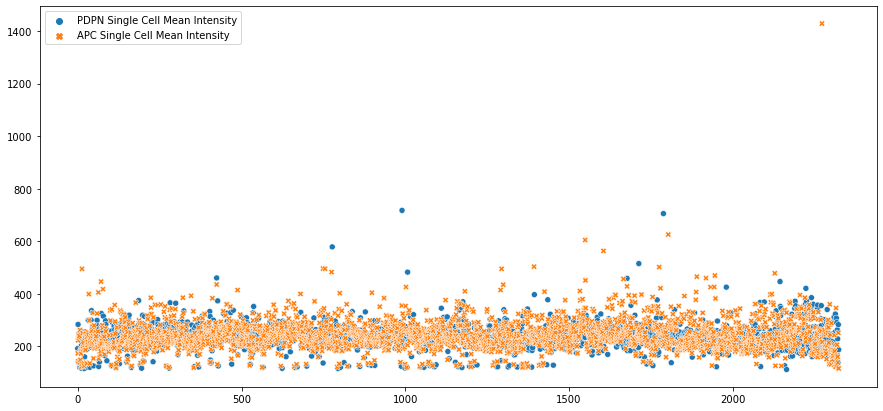

In [18]:
sns.scatterplot(data = mean_int_dict)

Text(0, 0.5, 'Mean Fluorescence Intensity')

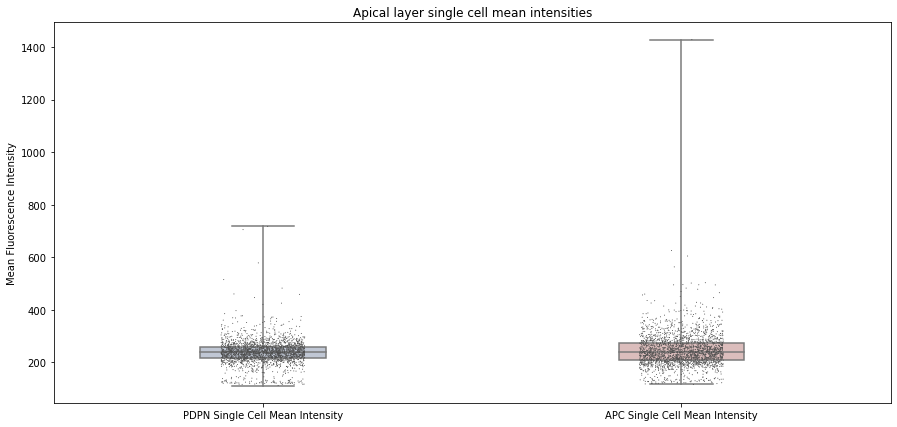

In [26]:
sns.stripplot(data=mean_int_dict,
              size=1, color=".3", linewidth=0)
# Plot the orbital period with horizontal boxes
sns.boxplot(data=mean_int_dict,
            whis=[0, 100], width=0.3, palette="vlag")
plt.title('Apical layer single cell mean intensities')
plt.ylabel('Mean Fluorescence Intensity')

### Visualise the data

In [27]:
visualise_pdpn_final_tracks, properties, graph = btrack.utils.tracks_to_napari(pdpn_tracks_final, ndim=2)
visualise_spc_final_tracks, properties, graph = btrack.utils.tracks_to_napari(spc_tracks_final, ndim=2)

In [28]:
viewer = napari.Viewer()

viewer = napari.Viewer()
viewer.add_image(dapi, colormap='blue', blending = 'additive')
viewer.add_image(zo1, colormap= 'yellow', blending = 'additive')
viewer.add_image(spc, colormap='green', blending = 'additive')
viewer.add_image(pdpn, colormap= 'red', blending = 'additive')

#viewer.add_labels(basal_mask_stack)
viewer.add_labels(apical_mask_stack)

viewer.add_tracks(visualise_pdpn_final_tracks, name = 'pdpn')
viewer.add_tracks(visualise_spc_final_tracks, name = 'spc')

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'spc [1]' at 0x7fa287b44f70>

### example positive pdpn track

In [37]:
[track for track in pdpn_tracks_final if track.ID == 2543][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,axis_minor_length,area,mean_intensity,eccentricity,axis_major_length,orientation
0,2543,28,904.683876,775.221672,0.0,2543,2543,5,0,False,31.184458,913,114.049288,0.554792,37.481824,0.094790
1,2543,29,905.521728,773.787747,0.0,2543,2543,5,0,False,40.126211,1351,115.586973,0.359747,43.005423,0.034875
2,2543,30,904.822347,773.014218,0.0,2543,2543,5,0,False,45.280177,1637,117.420281,0.232587,46.556973,-0.093835
3,2543,31,905.280067,772.318682,0.0,2543,2543,5,0,False,43.442511,1617,119.440940,0.432681,48.186627,0.261010
4,2543,32,904.690231,771.678378,0.0,2543,2543,5,0,False,42.557368,1612,122.311414,0.500742,49.165360,0.329785
5,2543,33,904.507126,771.909448,0.0,2543,2543,5,0,False,41.808871,1586,126.706179,0.537895,49.594652,0.453922
6,2543,34,904.590023,772.447444,0.0,2543,2543,5,0,False,41.299142,1519,134.857143,0.514731,48.170592,0.511322
7,2543,35,904.973680,772.760304,0.0,2543,2543,5,0,False,41.099380,1478,148.556157,0.484613,46.985283,0.343470
8,2543,36,904.927728,772.993461,0.0,2543,2543,5,0,False,40.886267,1458,173.687929,0.474055,46.435536,0.280698
9,2543,37,904.850730,772.996911,0.0,2543,2543,5,0,False,40.813704,1462,218.545828,0.483102,46.614182,0.369801


In [49]:
[track for track in pdpn_tracks_final if track.ID == 2152][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,axis_minor_length,area,mean_intensity,eccentricity,axis_major_length,orientation
0,2152,26,661.869170,1024.490202,0.0,2152,2152,5,0,False,34.173323,1083,126.192059,0.544344,40.737729,1.136450
1,2152,27,661.812149,1024.061039,0.0,2152,2152,5,0,False,37.903765,1248,128.963942,0.443454,42.289276,1.157353
2,2152,28,662.610032,1023.653906,0.0,2152,2152,5,0,False,37.337371,1271,133.653029,0.522132,43.778791,1.239166
3,2152,29,662.769605,1024.083274,0.0,2152,2152,5,0,False,35.557163,1205,141.560996,0.577534,43.555378,1.203981
4,2152,30,662.305549,1024.269201,0.0,2152,2152,5,0,False,36.122313,1217,152.076417,0.547578,43.169549,1.281235
5,2152,31,662.363640,1024.273158,0.0,2152,2152,5,0,False,35.993432,1206,168.637645,0.544529,42.913584,1.177893
6,2152,32,662.208185,1024.354858,0.0,2152,2152,5,0,False,35.195580,1187,196.005897,0.578361,43.143424,1.172082
7,2152,33,661.716246,1024.340602,0.0,2152,2152,5,0,False,35.328739,1176,244.160714,0.557101,42.541936,1.192219
8,2152,34,661.443642,1024.147600,0.0,2152,2152,5,0,False,35.566810,1179,329.841391,0.542492,42.338370,1.145456
9,2152,35,661.579322,1024.102451,0.0,2152,2152,5,0,False,35.914358,1195,441.293724,0.535906,42.538557,1.174262


### Max intensity of each single cell

In [38]:
max_int_dict = pd.DataFrame(columns=['PDPN Single Cell Max Intensity','SPC Single Cell Max Intensity'] )
for n, (pdpn_track, spc_track) in enumerate(zip(pdpn_tracks_final, spc_tracks_final)):
    single_cell_pdpn = max(pdpn_track.properties['mean_intensity'])
    single_cell_spc = max(spc_track.properties['mean_intensity'])
    max_int_dict.loc[n] = [single_cell_pdpn, single_cell_spc]

In [39]:
max_int_dict

,PDPN Single Cell Max Intensity,SPC Single Cell Max Intensity
0,329.030197,273.378630
1,605.951496,414.660469
2,185.079208,182.163366
3,525.092437,481.487003
4,488.659919,419.058415
...,...,...
2319,282.929982,205.891037
2320,246.593312,180.875197
2321,149.949721,142.444492
2322,296.145304,269.135305


Text(0, 0.5, 'Max Fluorescence Intensity')

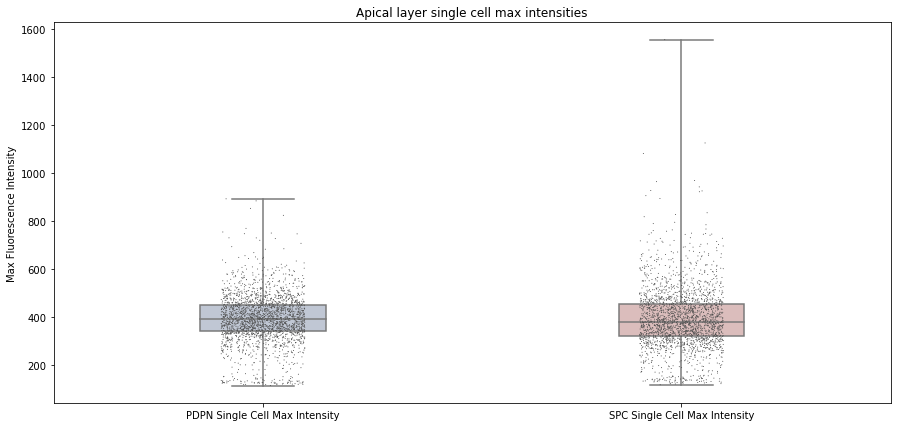

In [42]:
sns.stripplot(data=max_int_dict,
              size=1, color=".3", linewidth=0)
# Plot the orbital period with horizontal boxes
sns.boxplot(data=max_int_dict,
            whis=[0, 100], width=0.3, palette="vlag")
plt.title('Apical layer single cell max intensities')
plt.ylabel('Max Fluorescence Intensity')

Text(0, 0.5, 'Mean intensity of PDPN')

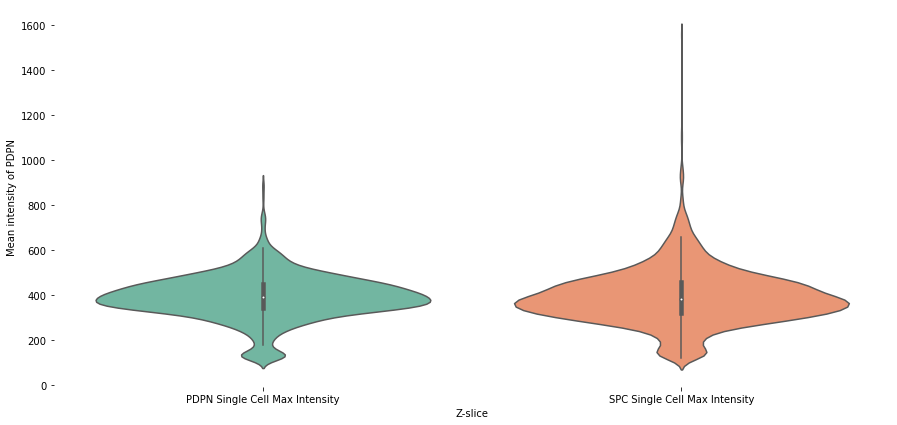

In [43]:
sns.violinplot(data=max_int_dict, palette="Set2", split=True,
                    scale="count", #inner="stick",
                    scale_hue=False, bw=.2)
sns.despine(left=True, bottom=True)
plt.xlabel('Z-slice')
plt.ylabel('Mean intensity of PDPN')

In [50]:
cutoff_pdpn = 200
cutoff_spc = 200

"Positive" PPDN Apical cells

In [48]:
len(max_int_dict[max_int_dict['PDPN Single Cell Max Intensity']>cutoff_pdpn])

2223

"Positive" SPC Apical cells

In [51]:
len(max_int_dict[max_int_dict['SPC Single Cell Max Intensity']>cutoff_spc])

2207

  replacements made: ['viewtransformf', 'raycasting_setup', 'before_loop', 'in_loop', 'after_loop', 'sampler_type', 'post', 'pre', 'clip_with_planes', 'cmap', 'get_data']
Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 903, in paintGL
    self._vispy_canvas.events.draw(region=None)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 218, in on_draw
    self._draw_scene()
  File "/home/dayn/miniconda3/envs/aero

Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 903, in paintGL
    self._vispy_canvas.events.draw(region=None)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 218, in on_draw
    self._draw_scene()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 277, in _draw_scene
    self.draw_visual(self.scene)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-p

Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 903, in paintGL
    self._vispy_canvas.events.draw(region=None)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 218, in on_draw
    self._draw_scene()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 277, in _draw_scene
    self.draw_visual(self.scene)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-p

Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 903, in paintGL
    self._vispy_canvas.events.draw(region=None)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 218, in on_draw
    self._draw_scene()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 277, in _draw_scene
    self.draw_visual(self.scene)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-p